# Video Data Preprocessing 

## 0. Package Import

In [1]:
import pandas as pd
from trim_videos import trim_videos
from generate_neg_samples import generate_samples

## 1. Convert txt annotations to csv
   - Input: Original AVE dataset annotations in `../data_samples/dataset info/Annotations.txt` 
   - Output: `ave_annotations_preprocessed.csv` with columns: Category, VideoID, Quality, StartTime, EndTime, Duration
   - Purpose: Makes the annotations more accessible and easier to work with in Python

In [2]:
# Initialize a list to store the parsed data
annotations = []

# Read the file line by line
with open('../dataset info/Annotations.txt', 'r') as file:
    # Skip the header line
    next(file)
    for line in file:
        # Split the line into components
        parts = line.strip().split('&')
        if len(parts) == 5:  # Ensure the line has all 5 fields
            category, video_id, quality, start_time, end_time = parts
            annotations.append({
                'Category': category,
                'VideoID': video_id,
                'Quality': quality,
                'StartTime': float(start_time),
                'EndTime': float(end_time)
            })

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(annotations)

print(df.head())

      Category      VideoID Quality  StartTime  EndTime
0  Church bell  RUhOCu3LNXM    good        0.0     10.0
1  Church bell  MH3m4AwEcRY    good        6.0      8.0
2  Church bell  2An2JMGMbbs    good        0.0     10.0
3  Church bell  WM5R44UMLq0    good        0.0     10.0
4  Church bell  5wHd0VafUAA    good        0.0     10.0


In [3]:
unique_qualities = df['Quality'].unique()
print("Unique Quality Values:", unique_qualities)

Unique Quality Values: ['good']


In [4]:
def preprocess_annotations(input_file: str, output_csv: str) -> None:
    """
    Parse the AVE dataset annotations file and save as a CSV.
    
    Args:
        input_file (str): Path to the input `annotations.txt` file.
        output_csv (str): Path to save the output CSV file.
    """
    # Initialize a list to store parsed data
    annotations = []
    
    # Read and parse the file
    with open(input_file, 'r') as file:
        # Skip the header line
        next(file)
        
        for line in file:
            # Split each line into components
            parts = line.strip().split('&')
            
            # Ensure the line has all 5 fields
            if len(parts) == 5:
                category, video_id, quality, start_time, end_time = parts
                
                # Calculate duration (optional)
                duration = float(end_time) - float(start_time)
                
                # Store parsed data
                annotations.append({
                    'Category': category,
                    'VideoID': video_id,
                    'Quality': quality,
                    'StartTime': float(start_time),
                    'EndTime': float(end_time),
                    'Duration': duration  # Optional field
                })
    
    # Convert to DataFrame
    df = pd.DataFrame(annotations)
    
    # Save to CSV
    df.to_csv(output_csv, index=False)
    print(f"Preprocessed data saved to: {output_csv}")

In [5]:
# Save annotated data to csv file for easier use
input_file = "../dataset info/Annotations.txt"  
output_csv = "ave_annotations_preprocessed.csv"  # Output CSV path
preprocess_annotations(input_file, output_csv)


Preprocessed data saved to: ave_annotations_preprocessed.csv


## 2. Trim videos according to annotations
The annotations contain the `StartTime` and `EndTime` of the youtube videos used for AVE training, however, the videos in the given dataset is not trimmed.

We saved the trimmed clips in `../data_samples/dataset info/trimmed_clips.zip`.

In [ ]:
# df = pd.read_csv("ave_annotations_preprocessed.csv") 
# video_dir = "../original_videos"  # Folder with downloaded YouTube videos
# output_dir = "../data_samples/trimmed_clips"   # Folder to save trimmed segments

# trim_videos(df, video_dir, output_dir)

## 3. Generate synthetic bad samples using existing videos 
In order to create a balanced dataset with both positive (aligned) and negative (misaligned) samples, we utilized original videos and preprocessed annotations to
    - Generated video samples in `generated_samples` directory
    - Saved metadata in `generated_samples_metadata.csv`
  
Types of misalignments we used:
   - Time shift: Audio delay relative to video
   - Noise: Added white noise to audio
   - Mute: Removed audio track
   - Distort: Audio waveform distortion


In [ ]:
df = pd.read_csv("ave_annotations_preprocessed.csv")
generate_samples(
    df,
    video_dir="../original_videos",  # Full videos (not pre-trimmed)
    output_dir="../data_samples/generated_samples",
    output_csv="generated_samples_metadata.csv"
)

## 4. Dataset Statistics

Analyze the generated dataset to understand its composition and characteristics.

<Axes: >

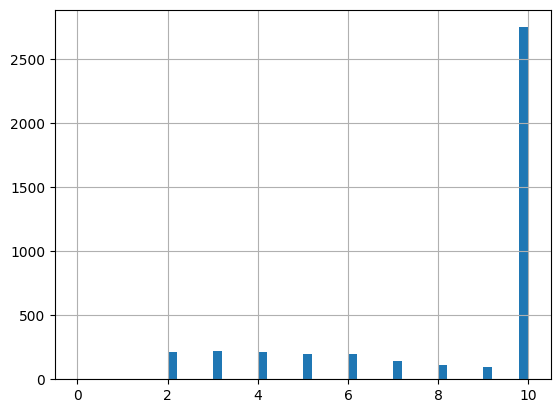

In [24]:
(df['EndTime'] - df['StartTime']).hist(bins=50)


In [20]:
def save_plot(fig, filename):
    """Save the current figure to a file in the main directory."""
    fig.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Saved plot to: {filename}")


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Read the generated samples metadata
df_samples = pd.read_csv("generated_samples_metadata.csv")

# Basic statistics
total_segments = len(df_samples)
pos_samples = len(df_samples[df_samples['Label'] == 'Positive'])
neg_samples = len(df_samples[df_samples['Label'] == 'Negative'])

print(f"Total segments: {total_segments}")
print(f"Positive samples: {pos_samples} ({pos_samples/total_segments*100:.1f}%)")
print(f"Negative samples: {neg_samples} ({neg_samples/total_segments*100:.1f}%)")

# Misalignment type distribution
misalignment_counts = df_samples[df_samples['Label'] == 'Negative']['MisalignmentType'].value_counts()
print("\nMisalignment type distribution:")
for mis_type, count in misalignment_counts.items():
    print(f"{mis_type}: {count} ({count/neg_samples*100:.1f}%)")

Total segments: 12114
Positive samples: 6040 (49.9%)
Negative samples: 6074 (50.1%)

Misalignment type distribution:
noise: 1680 (27.7%)
distort: 1680 (27.7%)
mute: 1611 (26.5%)
time_shift: 1103 (18.2%)


Saved plot to: misalignment_distribution.png


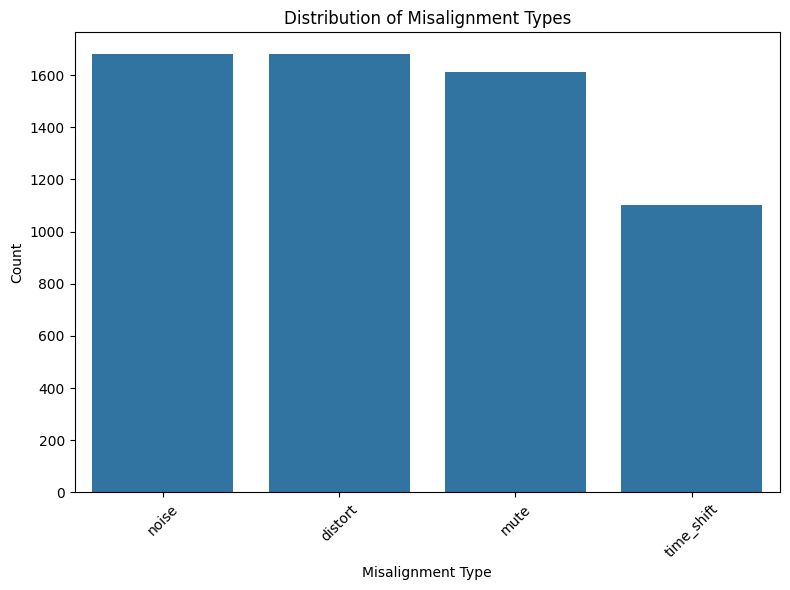

In [22]:
# Misalignment Distribution Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=misalignment_counts.index, y=misalignment_counts.values)
plt.title('Distribution of Misalignment Types')
plt.xlabel('Misalignment Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
save_plot(plt.gcf(), 'misalignment_distribution.png')
plt.show()

Duration Statistics (seconds):
count    12114.000000
mean         2.835727
std          1.982548
min          1.000000
25%          1.230000
50%          2.040000
75%          3.920000
max          9.000000
Name: Duration, dtype: float64
Saved plot to: duration_distribution.png


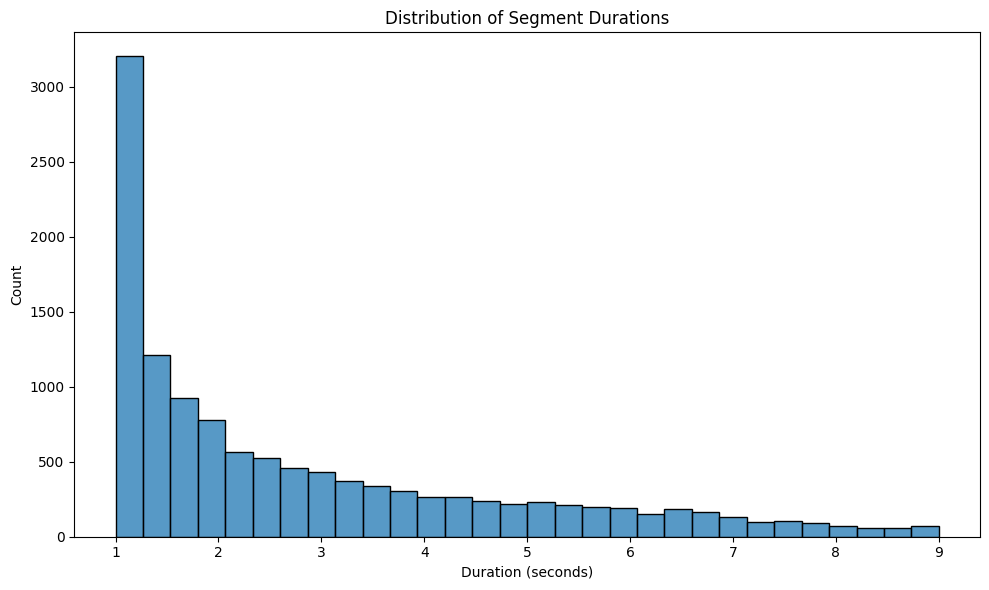

In [23]:
# Duration Analysis

# Calculate segment durations
df_samples['Duration'] = df_samples['EndTime'] - df_samples['StartTime']

# Duration statistics
print("Duration Statistics (seconds):")
print(df_samples['Duration'].describe())

# Plot duration distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df_samples, x='Duration', bins=30)
plt.title('Distribution of Segment Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.tight_layout()
save_plot(plt.gcf(), 'duration_distribution.png')
plt.show()


Number of unique categories: 28

Top 10 categories:
Category
Church bell                      555
Violin, fiddle                   551
Banjo                            542
Acoustic guitar                  542
Fixed-wing aircraft, airplane    540
Race car, auto racing            538
Frying (food)                    537
Flute                            534
Female speech, woman speaking    532
Helicopter                       531
Name: count, dtype: int64
Saved plot to: category_distribution.png


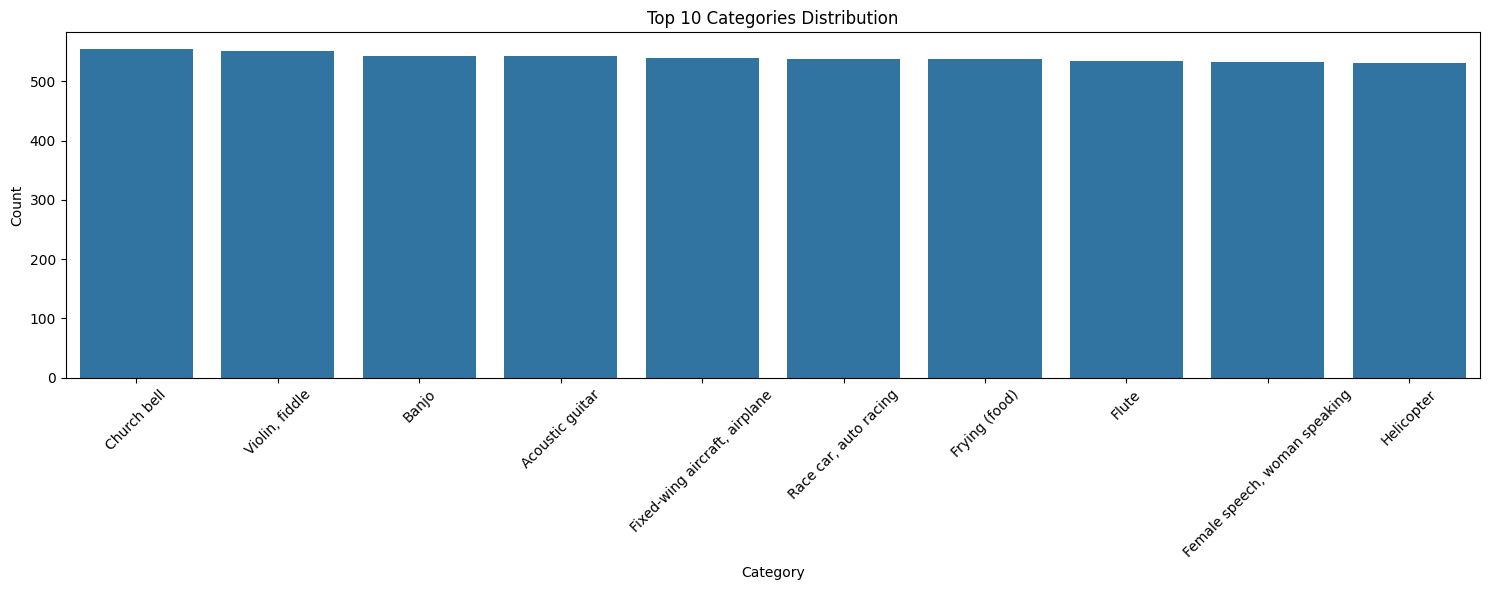

In [11]:
# Category distribution
category_counts = df_samples['Category'].value_counts()
print(f"\nNumber of unique categories: {len(category_counts)}")
print("\nTop 10 categories:")
print(category_counts.head(10))

# Plot category distribution
plt.figure(figsize=(15, 6))
sns.barplot(x=category_counts.head(10).index, y=category_counts.head(10).values)
plt.title('Top 10 Categories Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
save_plot(plt.gcf(), 'category_distribution.png')
plt.show()